In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"

In [2]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_98_80.h5ad'
adata = sc.read_h5ad(adata_with_labels_file)

In [3]:
adata

AnnData object with n_obs × n_vars = 20916 × 1299
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'co

In [4]:
female_adata = adata[adata.obs['sex'] == 'F']
#male_adata = adata[adata.obs['sex'] == 'M']

In [ ]:
# # write male and female adata to h5ad files
# female_adata.write_h5ad(os.path.join(working_dir, 'female_scANVI_v2.h5ad'))
# male_adata.write_h5ad(os.path.join(working_dir, 'male_scANVI_v2.h5ad'))

In [5]:
female_adata.X = female_adata.layers["log1p_norm_cb"]
print(female_adata.X.max())
print(female_adata.X.min())

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_28776/3147658925.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  female_adata.X = female_adata.layers["log1p_norm_cb"]


4.8368278
0.0


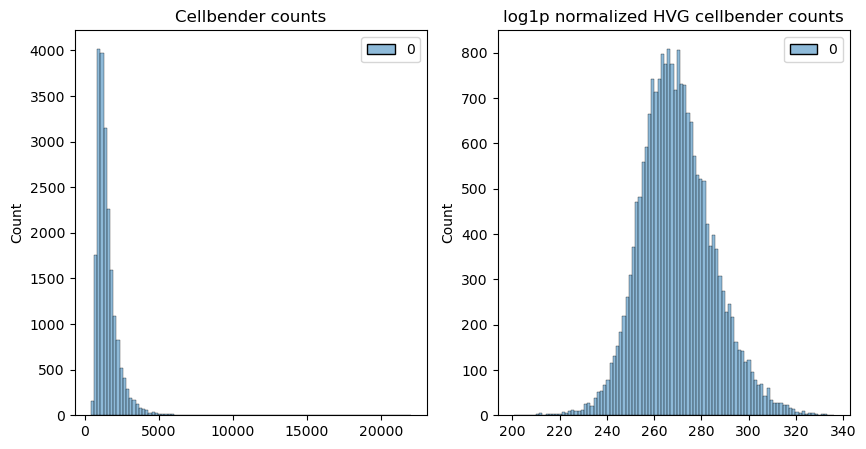

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(female_adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(female_adata.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p normalized HVG cellbender counts")
# p1 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Log1p normalized counts")
plt.show()

#### Sparsity based filtering

In [7]:
import numpy as np
from scipy.sparse import issparse

def calculate_zero_proportion(adata, axis='genes'):
    """
    Calculate the proportion of zeros for either genes (features) or cells in an AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing gene expression data
    axis : str, default 'genes'
        Which axis to calculate zeros for:
        - 'genes' or 'features' or 'columns': calculate zeros per gene (column-wise)
        - 'cells' or 'rows': calculate zeros per cell (row-wise)
        
    Returns:
    --------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each gene or cell
    """
    if axis.lower() in ['genes', 'features', 'columns']:
        # Calculate zeros per gene (column-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_cells = adata.n_obs
            non_zero_per_gene = np.array((adata.X != 0).sum(axis=0)).flatten()
            zero_per_gene = n_cells - non_zero_per_gene
            proportion_zeros = zero_per_gene / n_cells
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=0) / adata.n_obs
            
    elif axis.lower() in ['cells', 'rows']:
        # Calculate zeros per cell (row-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_genes = adata.n_vars
            non_zero_per_cell = np.array((adata.X != 0).sum(axis=1)).flatten()
            zero_per_cell = n_genes - non_zero_per_cell
            proportion_zeros = zero_per_cell / n_genes
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=1) / adata.n_vars
    else:
        raise ValueError("axis must be 'genes', 'features', 'columns', 'cells', or 'rows'")
    
    return proportion_zeros

def plot_sparsity_analysis(proportion_zeros, str='features', figsize=(14, 5), bins=50, 
                                color='steelblue', alpha=0.7, show_stats=True):
    """
    Plot cell/feature sparsity analysis with histogram and cumulative distribution.
    
    Parameters:
    -----------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each feature/cell
    figsize : tuple, default (14, 5)
        Figure size for the plots
    bins : int, default 50
        Number of bins for the histogram
    color : str, default 'steelblue'
        Color for the histogram bars
    alpha : float, default 0.7
        Transparency for the histogram bars
    show_stats : bool, default True
        Whether to print summary statistics
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : numpy.ndarray
        Array of axes objects
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Histogram of cell/feature sparsity
    axes[0].hist(proportion_zeros, bins=bins, edgecolor='black', alpha=alpha, color=color)
    axes[0].set_xlabel('Proportion of zeros')
    axes[0].set_ylabel('Number of ' + str)
    axes[0].set_title('Sparsity')
    axes[0].axvline(proportion_zeros.mean(), color='red', linestyle='--', 
                    label=f'Mean = {proportion_zeros.mean():.2f}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_props = np.sort(proportion_zeros)
    cumulative = np.arange(1, len(sorted_props) + 1) / len(sorted_props)
    axes[1].plot(sorted_props, cumulative, linewidth=2)
    axes[1].set_xlabel('Proportion of zeros')
    axes[1].set_ylabel('Cumulative fraction of ' + str)
    axes[1].set_title('Cumulative Distribution of Sparsity')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    if show_stats:
        print(f"Total {str}: {len(proportion_zeros)}")
        print(f"Mean proportion of zeros: {proportion_zeros.mean():.3f}")
        print(f"Median proportion of zeros: {np.median(proportion_zeros):.3f}")
        print(f"\n{str} by sparsity:")
        print(f"  >95% zeros: {(proportion_zeros > 0.95).sum()} {str} ({(proportion_zeros > 0.95).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >94% zeros: {(proportion_zeros > 0.94).sum()} {str} ({(proportion_zeros > 0.94).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >90% zeros: {(proportion_zeros > 0.90).sum()} {str} ({(proportion_zeros > 0.90).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  All zeros:  {(proportion_zeros == 1.0).sum()} {str}")
    
    return fig, axes


In [54]:
proportion_zeros_feature = calculate_zero_proportion(female_adata, axis='features')

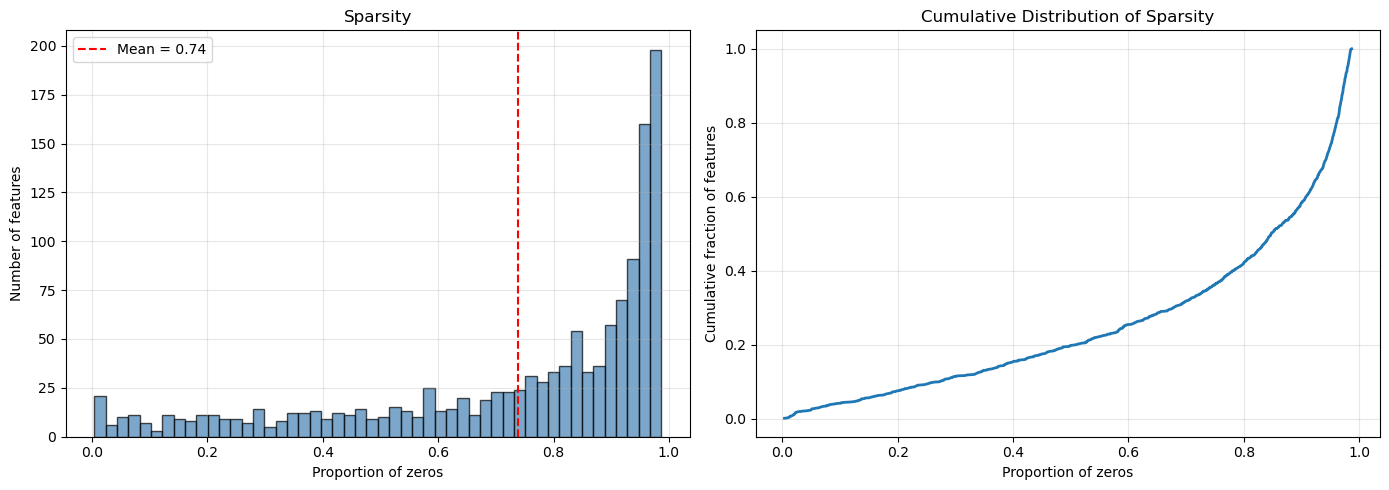

Total features: 1299
Mean proportion of zeros: 0.738
Median proportion of zeros: 0.848

features by sparsity:
  >95% zeros: 343 features (26.4%)
  >94% zeros: 398 features (30.6%)
  >90% zeros: 541 features (41.6%)
  All zeros:  0 features


In [58]:
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

In [39]:
# Remove genes with all zeros
genes_to_keep = proportion_zeros_feature < 0.98

print(f"Before filtering: {female_adata.n_vars} genes")
female_adata = female_adata[:, genes_to_keep]
print(f"After filtering: {female_adata.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} genes")

Before filtering: 4000 genes
After filtering: 1299 genes
Removed: 2701 genes


In [59]:
proportion_zeros_cell = calculate_zero_proportion(female_adata, axis='cells')

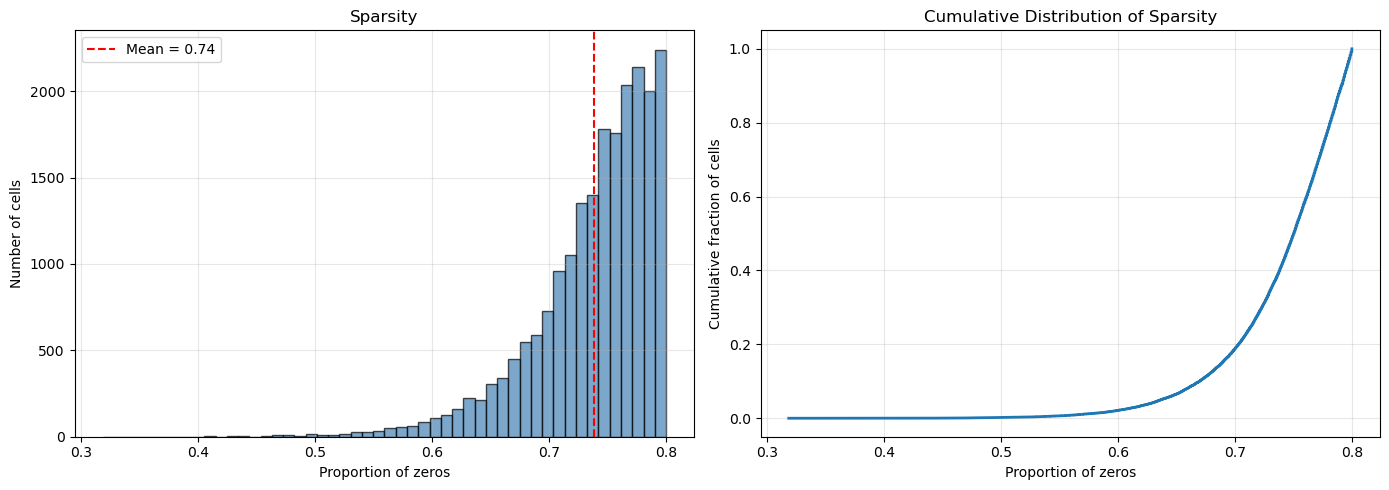

Total cells: 20916
Mean proportion of zeros: 0.738
Median proportion of zeros: 0.751

cells by sparsity:
  >95% zeros: 0 cells (0.0%)
  >94% zeros: 0 cells (0.0%)
  >90% zeros: 0 cells (0.0%)
  All zeros:  0 cells


In [61]:
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_cell, str='cells')

In [42]:
# Remove cells
cells_to_keep = proportion_zeros_cell < 0.8

print(f"Before filtering: {female_adata.n_obs} cells")
female_adata = female_adata[cells_to_keep, :]
print(f"After filtering: {female_adata.n_obs} cells")
print(f"Removed: {(~cells_to_keep).sum()} cells")

Before filtering: 43128 cells
After filtering: 20916 cells
Removed: 22212 cells


In [43]:
# Just run this again after cell filtering
sc.pp.filter_genes(female_adata, min_cells=100)
print(f"After re-filtering genes: {female_adata.n_vars} genes")

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After re-filtering genes: 1299 genes


In [66]:
female_adata.obs['sample_id']

AAACCCAAGATTCGAA-1    F7_KO
AAACCCACAGCCTTCT-1    F7_KO
AAACCCACAGTATGAA-1    F7_KO
AAACCCATCCGAGATT-1    F7_KO
AAACCCATCGACCATA-1    F7_KO
                      ...  
TGTGGTTGTCAGCTTG-1    F4_WT
TGTGGTTGTCTTGGGC-1    F4_WT
TGTGGTTGTGAACGCG-1    F4_WT
TGTGTTAGTCAACTGT-1    F4_WT
TGTGTTAGTTTACACA-1    F4_WT
Name: sample_id, Length: 20916, dtype: category
Categories (6, object): ['F3_WT', 'F4_WT', 'F7_KO', 'F15_WT', 'F706_KO', 'F785_KO']

In [62]:
# write male and female adata to h5ad files
female_adata.write_h5ad(os.path.join(working_dir, 'female_98_80.h5ad'))

### Filtering for slide

#### Subset to cell type of interest

In [47]:
female_adata_subset = female_adata[female_adata.obs['C_scANVI'] == 'Fast IIX']

In [48]:
female_adata_subset

View of AnnData object with n_obs × n_vars = 9910 × 1299
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_color

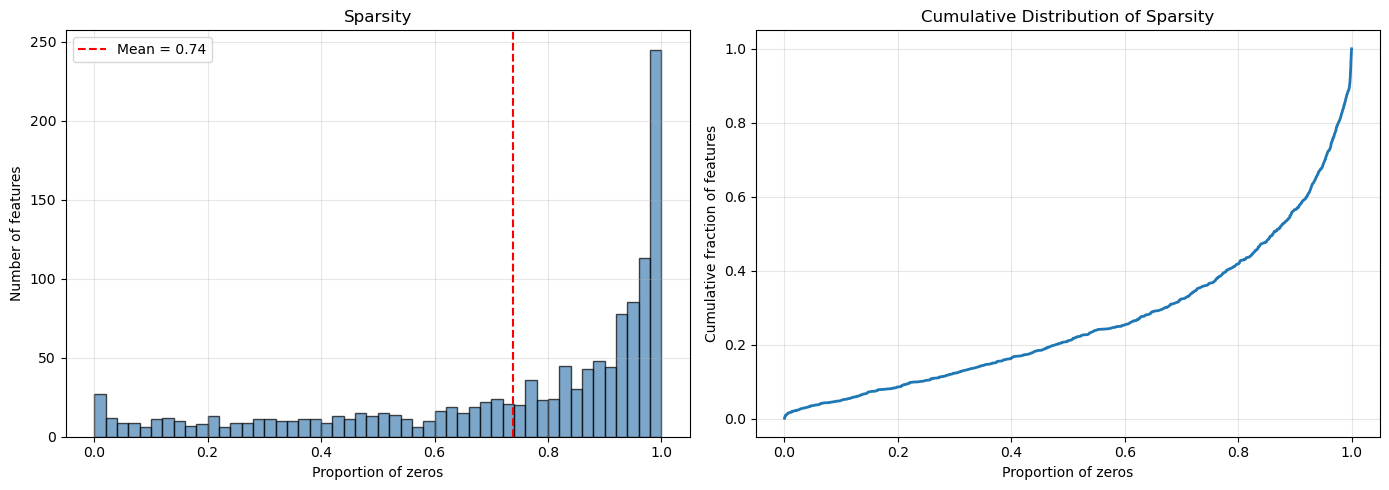

Total features: 1299
Mean proportion of zeros: 0.739
Median proportion of zeros: 0.862

features by sparsity:
  >95% zeros: 406 features (31.3%)
  >94% zeros: 443 features (34.1%)
  >90% zeros: 565 features (43.5%)
  All zeros:  1 features


In [49]:
proportion_zeros_feature = calculate_zero_proportion(female_adata_subset, axis='features')
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

In [50]:
genes_to_keep = proportion_zeros_feature < 0.97
print(f"Before filtering: {female_adata_subset.n_vars} genes")
female_adata_subset = female_adata_subset[:, genes_to_keep]
print(f"After filtering: {female_adata_subset.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} genes")

Before filtering: 1299 genes
After filtering: 1001 genes
Removed: 298 genes


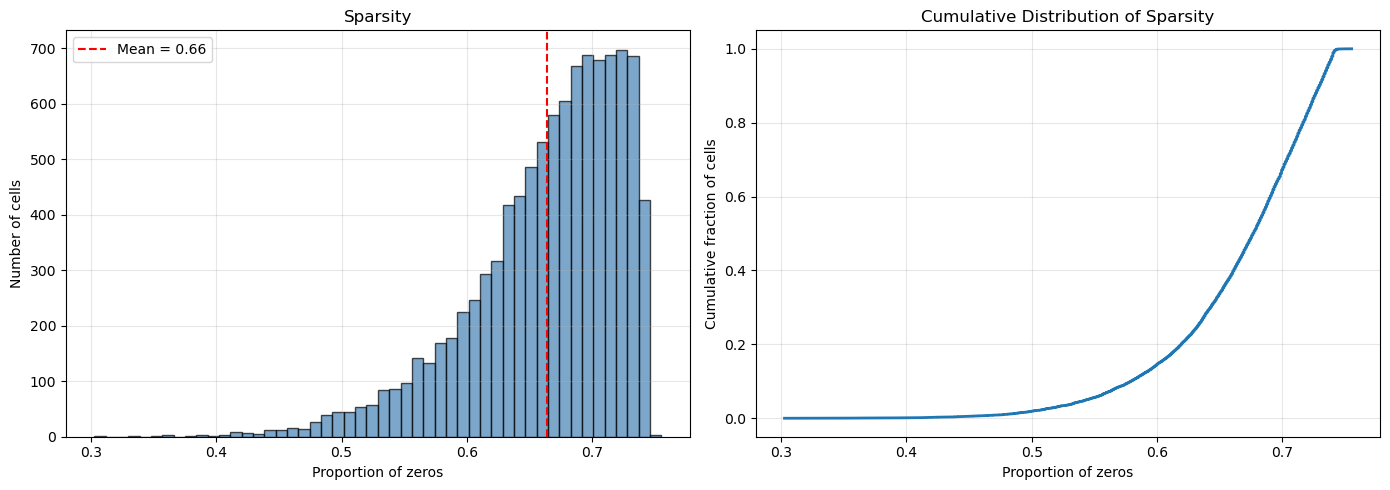

Total cells: 9910
Mean proportion of zeros: 0.664
Median proportion of zeros: 0.676

cells by sparsity:
  >95% zeros: 0 cells (0.0%)
  >94% zeros: 0 cells (0.0%)
  >90% zeros: 0 cells (0.0%)
  All zeros:  0 cells


In [51]:
proportion_zeros_cell = calculate_zero_proportion(female_adata_subset, axis='cells')
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_cell, str='cells')

### Variance filtering of features

In [52]:
# need to look at the variance of mean-centered data (normalized data)
female_adata_subset.X = female_adata_subset.layers["log1p_norm_cb"]

/tmp/ipykernel_28776/3724971261.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  female_adata_subset.X = female_adata_subset.layers["log1p_norm_cb"]


/tmp/ipykernel_28776/1702478790.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  female_adata_subset.var['variance'] = gene_variance


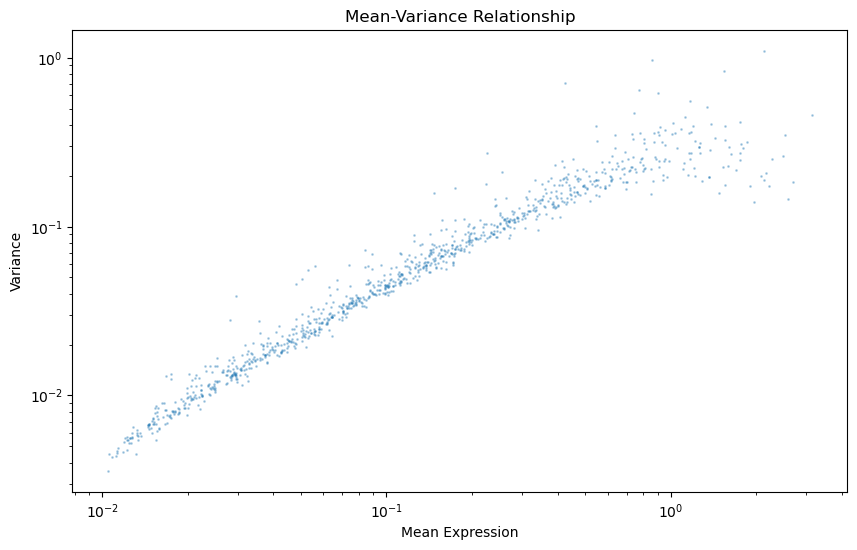

In [53]:
# Calculate mean and variance for each gene
gene_mean = np.mean(female_adata_subset.X.toarray() if hasattr(female_adata_subset.X, 'toarray') else female_adata_subset.X, axis=0)
gene_variance = np.var(female_adata_subset.X.toarray() if hasattr(female_adata_subset.X, 'toarray') else female_adata_subset.X, axis=0)

# Add variance to adata.var for easy access
female_adata_subset.var['variance'] = gene_variance

plt.figure(figsize=(10, 6))
plt.scatter(gene_mean, gene_variance, alpha=0.3, s=1)
plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.title('Mean-Variance Relationship')
plt.xscale('log')
plt.yscale('log')
plt.show()

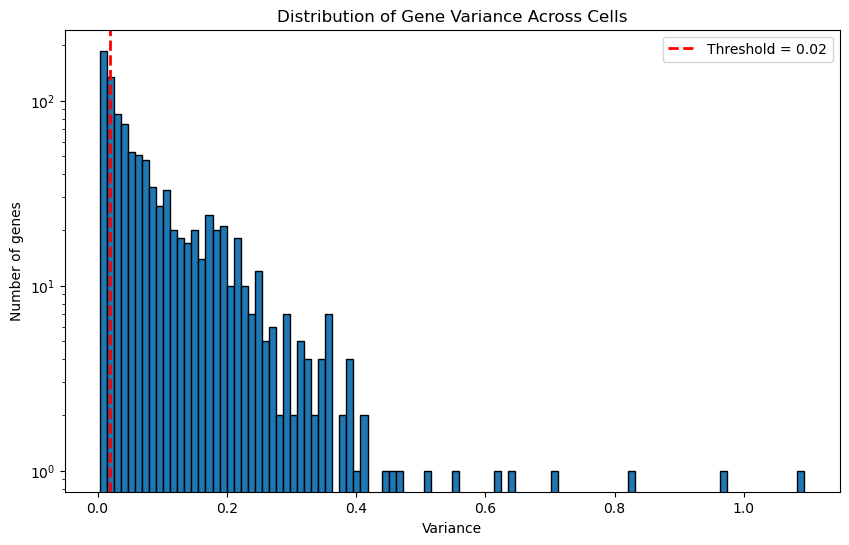

Total genes before filtering: 1001
Genes above threshold (0.02): 739
Genes below threshold: 262
Percentage kept: 73.83%


In [54]:
# Set threshold (adjust based on your distribution)
variance_threshold = 0.02

# Visualize the threshold
plt.figure(figsize=(10, 6))
plt.hist(gene_variance, bins=100, edgecolor='black')
plt.axvline(variance_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {variance_threshold}')
plt.xlabel('Variance')
plt.ylabel('Number of genes')
plt.title('Distribution of Gene Variance Across Cells')
plt.yscale('log')
plt.legend()
plt.show()

# Print filtering statistics
print(f"Total genes before filtering: {female_adata_subset.n_vars}")
print(f"Genes above threshold ({variance_threshold}): {np.sum(gene_variance >= variance_threshold)}")
print(f"Genes below threshold: {np.sum(gene_variance < variance_threshold)}")
print(f"Percentage kept: {100 * np.sum(gene_variance >= variance_threshold) / female_adata_subset.n_vars:.2f}%")

In [ ]:
# Filter adata to keep only high variance genes
female_adata_subset = female_adata_subset[:, female_adata_subset.var['variance'] >= variance_threshold].copy()
print(f"\nGenes after filtering: {female_adata_subset.n_vars}")


Genes after filtering: 739


In [64]:
female_adata_subset

AnnData object with n_obs × n_vars = 9910 × 739
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells', 'variance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_co

In [65]:
# Create Y matrix with binary encoding: KO=1, WT=0
Y = pd.DataFrame(female_adata_subset.obs['condition'], index=female_adata_subset.obs_names, columns=['condition'])

# Map condition to binary class
Y['Class'] = Y['condition'].map({'KO': 1, 'WT': 0})

# Keep only the class column
Y = Y[['Class']]

# rename the obs_names tp Barcode
Y.index.name = 'Barcode'

display(Y)

,Class
Barcode,
AAACCCAAGATTCGAA-1,1
AAACCCACAGCCTTCT-1,1
AAACCCACAGTATGAA-1,1
AAACCCATCCGAGATT-1,1
AAACCCATCGACCATA-1,1
...,...
TGTGCATGTGACTCTG-1,0
TGTGCCAGTGCGTGAG-1,0
TGTGGTTGTCAGCTTG-1,0


In [66]:
# convert to df with rows as cell barcodes and columns as gene names and the X matrix as values
female_adata_df = pd.DataFrame(female_adata_subset.X.toarray(), index=female_adata_subset.obs_names, columns=female_adata_subset.var_names)
female_adata_df

,Slco5a1,Stau2,Jph1,Gm28653,Kcnq5,Vwa3b,Slc40a1,Ankrd44,Plcl1,Aox1,...,Smpx,Sh3kbp1,Cdkl5,Rai2,Asb11,Arhgap6,Gm15261,Mid1,Gm47283,Tmlhe
Barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATTCGAA-1,0.000000,1.443148,1.562976,0.000000,1.562976,0.431133,0.0,0.0,0.000000,0.431133,...,0.431133,0.00000,0.0,0.431133,0.000000,0.731407,0.000000,0.431133,0.962030,0.000000
AAACCCACAGCCTTCT-1,0.877624,0.000000,1.557543,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.384169,...,0.000000,0.00000,0.0,0.661030,0.877624,0.384169,0.000000,0.000000,0.661030,0.000000
AAACCCACAGTATGAA-1,1.183575,0.373772,0.645222,0.000000,1.183575,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.0,0.000000,0.000000,1.034188,0.000000,0.000000,0.858499,0.000000
AAACCCATCCGAGATT-1,0.622164,0.454448,1.555927,0.000000,1.909993,0.252820,0.0,0.0,0.000000,1.194291,...,0.252820,0.25282,0.0,0.454448,0.252820,0.252820,0.000000,0.252820,0.454448,0.000000
AAACCCATCGACCATA-1,0.797070,1.039762,1.398117,0.000000,2.041825,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.0,0.000000,0.000000,1.770896,0.475932,0.475932,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGCATGTGACTCTG-1,0.761934,0.000000,1.066098,0.566228,0.000000,0.000000,0.0,0.0,0.566228,0.000000,...,0.000000,0.00000,0.0,0.000000,0.322667,1.189315,0.000000,0.000000,0.322667,0.000000
TGTGCCAGTGCGTGAG-1,0.457198,0.000000,1.007566,0.457198,1.199533,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.769777,0.000000
TGTGGTTGTCAGCTTG-1,0.000000,0.741621,1.528684,0.000000,1.112392,0.145872,0.0,0.0,0.386040,0.273149,...,0.487470,0.00000,0.0,0.000000,0.663867,0.741621,0.000000,0.000000,0.145872,0.145872


In [69]:
# Sort Y by Class
Y_sorted = Y.sort_values('Class', ascending=True)

# Reorder female_adata_df to match the same order
female_adata_df_sorted = female_adata_df.loc[Y_sorted.index]

# Verify the order is synchronized
print("Y sorted:")
display(Y_sorted)
print(f"\nKO samples (Class=1): {(Y_sorted['Class'] == 1).sum()}")
print(f"WT samples (Class=0): {(Y_sorted['Class'] == 0).sum()}")

print("\nX matrix sorted:")
display(female_adata_df_sorted)

# Verify indices match
print(f"\nIndices match: {(Y_sorted.index == female_adata_df_sorted.index).all()}")

Y sorted:


,Class
Barcode,
CCTCAGTCAATCTGAA-1,1
GGTTCTCGTGACACAG-1,1
GGTTCTCTCCCGAATA-1,1
GGTTGTACACAGTGAG-1,1
GGTTGTAGTTTCGTTT-1,1
...,...
CACATTAGTCTTGCCT-1,0
CACCAATGTAACGTAG-1,0
CACCAATGTTGTGGAA-1,0



KO samples (Class=1): 4433
WT samples (Class=0): 5477

X matrix sorted:


,Slco5a1,Stau2,Jph1,Gm28653,Kcnq5,Vwa3b,Slc40a1,Ankrd44,Plcl1,Aox1,...,Smpx,Sh3kbp1,Cdkl5,Rai2,Asb11,Arhgap6,Gm15261,Mid1,Gm47283,Tmlhe
Barcode,,,,,,,,,,,,,,,,,,,,,
CCTCAGTCAATCTGAA-1,0.000000,1.250445,1.383860,0.0,1.383860,0.000000,0.0,0.000000,0.000000,0.404384,...,0.404384,0.000000,0.0,0.404384,1.096449,0.000000,0.000000,0.000000,1.250445,0.000000
GGTTCTCGTGACACAG-1,1.531616,1.313518,1.313518,0.0,1.313518,0.000000,0.0,0.645222,0.645222,0.373772,...,0.000000,0.000000,0.0,0.000000,0.645222,1.183575,0.000000,0.000000,0.373772,0.000000
GGTTCTCTCCCGAATA-1,0.000000,0.000000,0.608299,0.0,1.985101,0.000000,0.0,0.000000,0.813574,0.349707,...,0.349707,0.608299,0.0,0.000000,0.813574,1.561900,0.983803,0.349707,0.349707,0.000000
GGTTGTACACAGTGAG-1,1.051698,0.556756,1.174032,0.0,2.296571,0.000000,0.0,0.316635,0.912285,0.000000,...,0.000000,0.316635,0.0,0.000000,0.316635,1.283018,0.000000,0.000000,0.000000,0.000000
GGTTGTAGTTTCGTTT-1,0.000000,0.000000,1.727054,0.0,1.292621,0.000000,0.0,0.000000,1.727054,0.842067,...,0.000000,0.000000,0.0,0.000000,0.507167,0.507167,0.507167,0.000000,1.092507,0.507167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACATTAGTCTTGCCT-1,0.000000,0.000000,1.883491,0.0,1.431872,0.000000,0.0,0.000000,0.585914,0.952917,...,0.952917,0.000000,0.0,0.000000,0.585914,1.220799,0.000000,0.000000,0.585914,0.000000
CACCAATGTAACGTAG-1,0.608610,0.246306,0.873992,0.0,1.646613,0.000000,0.0,0.750079,1.173823,0.608610,...,0.443777,0.246306,0.0,0.000000,0.000000,1.591291,0.246306,0.246306,0.873992,0.000000
CACCAATGTTGTGGAA-1,0.751519,0.246903,1.648816,0.0,1.928785,0.246903,0.0,0.000000,0.000000,0.000000,...,0.444756,0.000000,0.0,0.000000,0.246903,0.246903,0.000000,0.000000,0.246903,0.000000



Indices match: True


In [70]:
# Update the original variables
Y = Y_sorted
female_adata_df = female_adata_df_sorted

In [71]:
#save to csv
out_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"
female_adata_df.to_csv(os.path.join(out_dir, 'female_adata_fast2x_X.csv'))

In [72]:
# save to csv
Y.to_csv(os.path.join(out_dir, 'female_adata_fast2x_Y.csv'))

## Run slide

In [ ]:
import loveslide
from loveslide import OptimizeSLIDE

/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
During startup - Warning messages:
1: package ‘methods’ was built under R version 4.4.3 
2: package ‘datasets’ was built under R version 4.4.3 
3: package ‘utils’ was built under R version 4.4.3 
4: package ‘grDevices’ was built under R version 4.4.3 
5: package ‘graphics’ was built under R version 4.4.3 
6: package ‘stats’ was built under R version 4.4.3 


In [ ]:
input_params = {
    'x_path': '/path/to/features.csv',
    'y_path': '/path/to/labels.csv',
    'fdr': 0.1,
    'thresh_fdr': 0.1,
    'spec': 0.2,
    'y_factor': True,
    'niter': 500,
    'SLIDE_top_feats': 20,
    'rep_CV': 50,
    'pure_homo': True,
    'delta': [0.01],
    'lambda': [0.5, 0.1],
    'out_path': '/path/to/output/'
}

slider = OptimizeSLIDE(input_params)
slider.run_pipeline(verbose=True, n_workers=1)